<a href="https://colab.research.google.com/github/lumigraph/AP2018/blob/master/DeepTemplateMatching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
top = '/content/template_matching_data'
for root, dirs, files in os.walk(top, topdown=False):
    for name in files:
        os.remove(os.path.join(root, name))
    for name in dirs:
        os.rmdir(os.path.join(root, name))

In [4]:
zip_path = '/content/drive/MyDrive/template_matching_data.zip'
!cp "{zip_path}" .
!unzip -q template_matching_data.zip
!rm template_matching_data.zip

In [5]:
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os

class TemplateMatchingDataset(Dataset):
  def __init__(self, root_dir, img_transform=None, tmp_transform=None):
    self.root_dir = root_dir
    self.img_transform = img_transform
    self.tmp_transform = tmp_transform
    self.samples = self.make_dataset(self.root_dir)

  def __len__(self):
    return len(self.samples)

  def __getitem__(self, idx):
    img_path, tmp_path, cls_id = self.samples[idx]
    img = self.pil_loader(img_path)
    tmp = self.pil_loader(tmp_path)
    if self.img_transform is not None:
      img = self.img_transform(img)
    if self.tmp_transform is not None:
      tmp = self.tmp_transform(tmp)
    return img, tmp, cls_id

  @staticmethod
  def make_dataset(directory: str):
    instances = []
    class_dirs = [(0, 'negative'), (1, 'positive')]

    for cls_dir in class_dirs:
      cls_pos = cls_dir[0]
      dir_pos = directory + '/' + cls_dir[1]

      if os.path.isdir(dir_pos):   
        files = os.listdir(dir_pos)
        num_samples = int(len(files) / 2)
        for i in range(num_samples):
          img_path = os.path.join(dir_pos, str(i) + '_image.jpg')
          tmp_path = os.path.join(dir_pos, str(i) + '_templ.jpg')
          item = img_path, tmp_path, cls_pos
          instances.append(item)
      else:
        raise FileNotFoundError(f"Couldn't find subfolder {dir_pos}.")

    return instances

  @staticmethod
  def pil_loader(path: str):
    with open(path, 'rb') as f:
      img = Image.open(f)
      return img.convert('RGB')

In [6]:
from torchvision.transforms import transforms

normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )


IMG_SIZE = (480, 640)
HEATMAP_SIZE = (29, 39)
TEMPLATE_SIZE = 124

PREPROCESS = [transforms.Compose([transforms.Scale(IMG_SIZE[0]), transforms.ToTensor(), normalize]),
              transforms.Compose([transforms.Scale(TEMPLATE_SIZE), transforms.ToTensor(), normalize]),
              transforms.Compose([transforms.Scale(TEMPLATE_SIZE), transforms.ToTensor()]),
              transforms.Compose([transforms.Scale(TEMPLATE_SIZE), transforms.ToTensor(), normalize]),
              transforms.Compose([transforms.Scale(TEMPLATE_SIZE), transforms.ToTensor()])
              ]

eps = 0.00001


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:310: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [7]:
import torch

data_dir = '/content/template_matching_data/'

# TODO: Define transforms for the training data and testing data
img_transforms = transforms.Compose([
#                                       transforms.RandomRotation(30),
#                                       transforms.RandomResizedCrop(224),
#                                       transforms.RandomHorizontalFlip(),
#                                       transforms.Resize(255),
#                                       transforms.CenterCrop(224),
                                      transforms.Resize(IMG_SIZE),
                                      transforms.ToTensor(),
                                      normalize])

tmp_transforms = transforms.Compose([
#                                      transforms.Resize(255),
#                                      transforms.CenterCrop(224),
                                      transforms.Resize((TEMPLATE_SIZE,TEMPLATE_SIZE)),
                                      transforms.ToTensor(),
                                      normalize])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = TemplateMatchingDataset(data_dir + '/train', img_transform=img_transforms, tmp_transform=tmp_transforms)
test_data = TemplateMatchingDataset(data_dir + '/test', img_transform=img_transforms, tmp_transform=tmp_transforms)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16)

In [8]:
train_iter = iter(train_loader)
test_iter = iter(test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


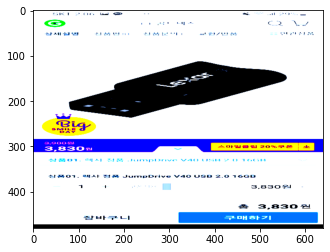

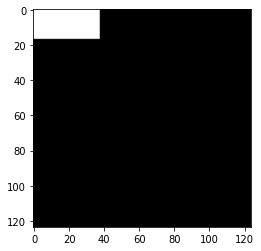

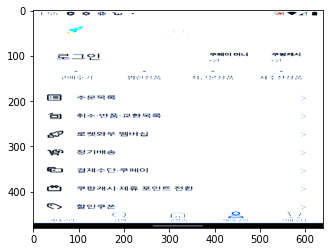

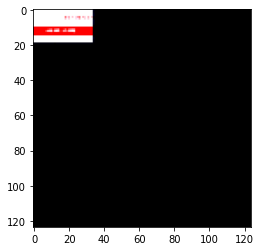

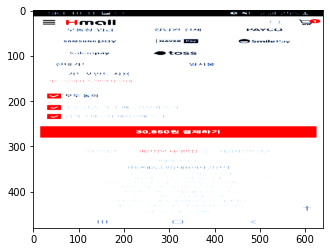

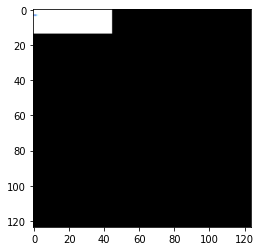

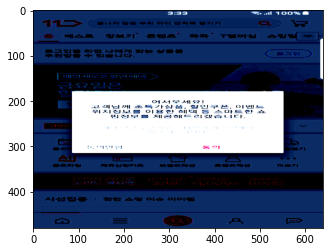

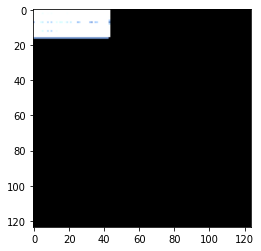

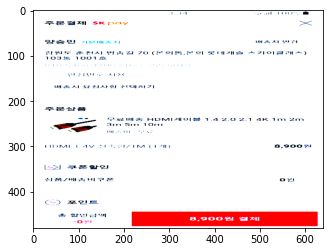

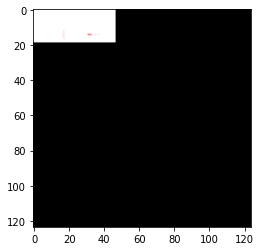

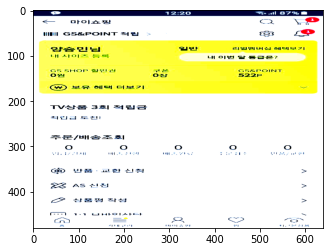

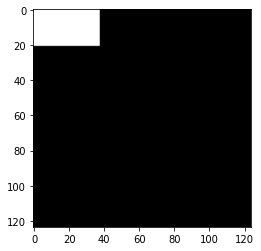

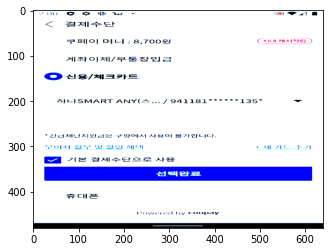

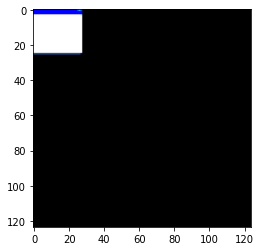

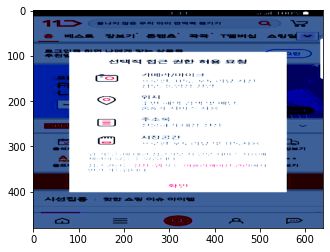

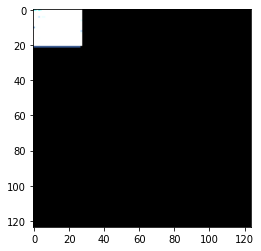

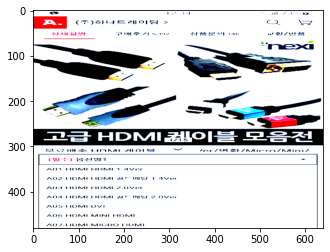

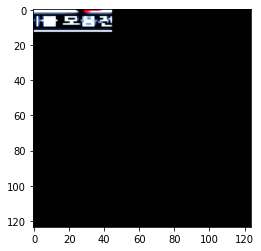

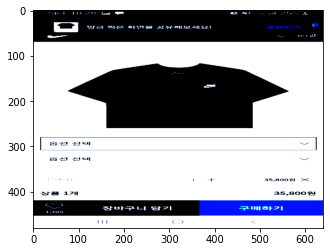

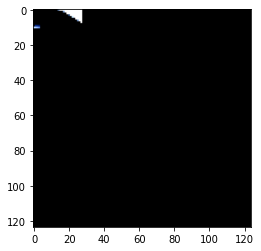

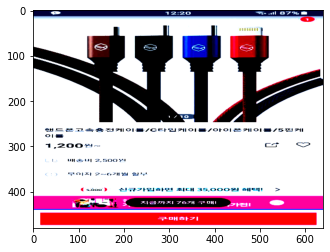

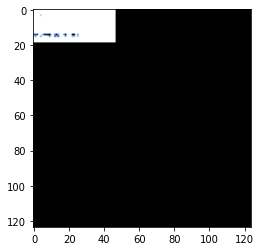

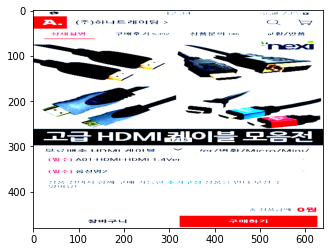

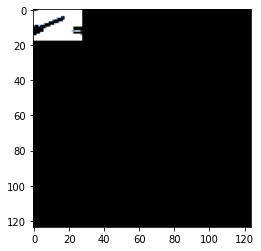

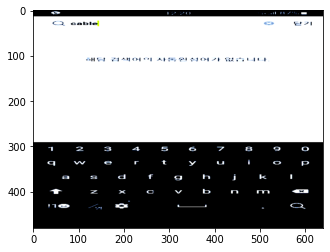

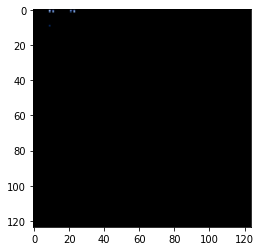

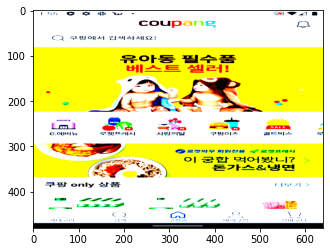

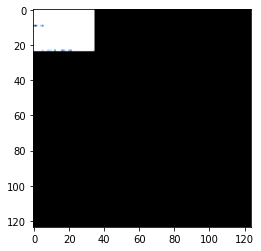

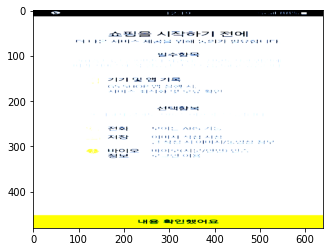

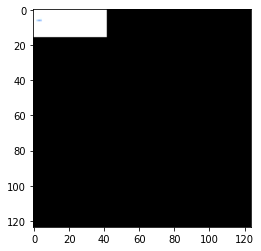

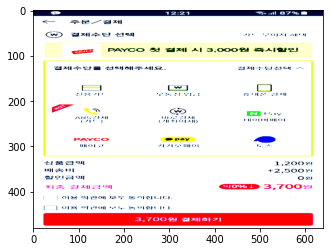

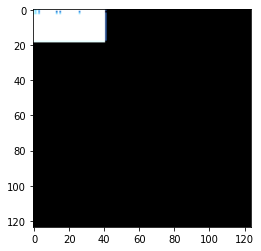

In [11]:
import matplotlib.pyplot as plt

train_images, train_templates, train_labels = next(train_iter)

with torch.no_grad():
    train_images, train_templates = train_images.to(device), train_templates.to(device)

#    test_logps = model.forward(test_inputs)
#    test_ps = torch.exp(test_logps)

    for i in range(len(train_images)):
        plt.figure()
        img = train_images[i].cpu().numpy().transpose(1,2,0).clip(0.0, 1.0)
        plt.imshow(img)

        plt.figure()
        tmp = train_templates[i].cpu().numpy().transpose(1,2,0).clip(0.0, 1.0)
        plt.imshow(tmp)

In [12]:
import json

import cv2
import math
import torch
import torchvision

import numpy as np
import random
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable

from torchvision import models
from torchvision.transforms import transforms


#from lib.nms.pth_nms import pth_nms

import torch.nn as nn
import torch
import collections
from abc import ABCMeta, abstractmethod

#from anchors import Anchors
#from network_base import NetworkBase


In [13]:
#Backbone
class ImageFeatExtract(nn.Module):
    def __init__(self):
        super(ImageFeatExtract, self).__init__()

        dense = models.densenet121(pretrained=True).features
        dense.transition3.pool = nn.AvgPool2d(kernel_size=2, stride=1, padding=0)
        modules_dense = list(dense.children())
        self.backdense_0 = torch.nn.Sequential(*modules_dense[:1])
        self.backdense_1 = torch.nn.Sequential(*modules_dense[1:5])
        self.backdense_2 = torch.nn.Sequential(*modules_dense[5:])

        self.c1 = nn.Conv2d(1024, 640, 1)
        self.n1 = nn.BatchNorm2d(640, affine=True)


    def forward(self, image, template_feat):

        x0 = self.backdense_0(image)
        x0_t = self.conv2d_dw_group(x0, template_feat, padding=1)
        x0_cat = x0 + x0_t

        x1 = self.backdense_1(x0_cat)
        x2 = self.backdense_2(x1)
        xf = self.n1 (F.elu(self.c1(x2)))
        return xf

    def conv2d_dw_group(self, x, kernel, padding=0):
        batch, channel = kernel.shape[:2]
        x = x.contiguous().view(1, batch * channel, x.size(2), x.size(3)) # 1 * (b*c) * k * k
        kernel = kernel.view(batch * channel, 1, kernel.size(2), kernel.size(3))  # (b*c) * 1 * H * W
        out = F.conv2d(x, kernel, groups=batch * channel, padding=padding)
        out = out.view(batch, channel, out.size(2), out.size(3))
        return out

In [14]:
#Object Attention Branch
class TemplateFeatExtractGlobal(nn.Module):
    def __init__(self, output_dim=1024):
        super(TemplateFeatExtractGlobal, self).__init__()

        self.backbone = models.squeezenet1_1(pretrained=True)
        modules = list(list(self.backbone.children())[0])

        # new conv with 3 channels and already trained weights
        #new_conv_0 = nn.Conv2d(3, 64, kernel_size=3, stride=2)
        #new_conv_0.weight[:, :3, :, :] = modules[0].weight
        #new_conv_0.weight = nn.Parameter(new_conv_0.weight)
        #new_conv_0.bias = modules[0].bias
        #new_conv_0.bias = nn.Parameter(new_conv_0.bias)       

        #self.backbone_0 = torch.nn.Sequential(new_conv_0)

        self.backbone_0 = torch.nn.Sequential(*modules[0:1])
        self.backbone_1 = torch.nn.Sequential(*modules[1:5])
        self.backbone_2 = torch.nn.Sequential(*modules[5:])

        self.norm_1 = nn.BatchNorm2d(128, affine=True)
        self.norm_2 = nn.BatchNorm2d(512, affine=True)

        self.final_conv_1 = nn.Conv2d(640, 128, 3)
        self.final_conv_2 = nn.Conv2d(128, 64, 3)

        self.final_norm_1 = nn.BatchNorm2d(128, affine=True)
        self.final_norm_2 = nn.BatchNorm2d(64, affine=True)

    def forward(self, img):
        x0 = self.backbone_0(img)

        x1 = self.backbone_1(x0)
        x2 = self.backbone_2(x1)

        x1_norm = self.norm_1(x1)
        x2_norm = self.norm_2(x2)

        kernel_size = x2.size(3)
        x1_down = F.upsample(x1_norm, size=kernel_size, mode='bilinear')

        xf = torch.cat([x2_norm, x1_down], dim=1)
        xf = self.final_norm_1 (F.elu(self.final_conv_1(xf)))
        xf = self.final_norm_2(F.elu(self.final_conv_2(xf)))

        return xf

In [15]:
#Pose Specific Branch
class TemplateFeatExtract(nn.Module):
    def __init__(self, output_dim=1024):
        super(TemplateFeatExtract, self).__init__()

        self.backbone = models.squeezenet1_1(pretrained=True)
        modules = list(list(self.backbone.children())[0])

        #new_conv_0 = nn.Conv2d(3, 64, kernel_size=3, stride=2)
        #new_conv_0.weight[:, :3, :, :] = modules[0].weight
        #new_conv_0.weight = nn.Parameter(new_conv_0.weight)
        #new_conv_0.bias = modules[0].bias
        #new_conv_0.bias = nn.Parameter(new_conv_0.bias)
        #self.backbone_0 = torch.nn.Sequential(new_conv_0)

        self.backbone_0 = torch.nn.Sequential(*modules[0:1])
        self.backbone_1 = torch.nn.Sequential(*modules[1:5])
        self.backbone_2 = torch.nn.Sequential(*modules[5:])

        self.norm_1 = nn.BatchNorm2d(128, affine=True)
        self.norm_2 = nn.BatchNorm2d(512, affine=True)

    def forward(self, img):

        x0 = self.backbone_0(img)

        x1 = self.backbone_1(x0)
        x2 = self.backbone_2(x1)

        x1_norm = self.norm_1(x1)
        x2_norm = self.norm_2(x2)

        kernel_size = x2.size(3)
        x1_down = F.upsample(x1_norm, size=kernel_size, mode='bilinear')

        xf = torch.cat([x2_norm, x1_down], dim=1)
        return xf


In [16]:
class CorrelationModel(nn.Module):
    def __init__(self, input_dim=1024):
        super(CorrelationModel, self).__init__()

        # additional layers to pose specific branch
        self.c1 = nn.Conv2d(input_dim, input_dim, 3, padding=0)
        self.n1 = nn.BatchNorm2d(input_dim, affine=True)

        self.c2 = nn.Conv2d(input_dim, input_dim, 3, padding=0)
        self.n2 = nn.BatchNorm2d(input_dim, affine=True)

        # correlation layers 
        self.corr_conv_dot = nn.Conv2d(input_dim, 256, 3, padding=1)
        self.norm_corr_dot = nn.BatchNorm2d(256, affine=True)

        self.corr_conv_dot3x3 = nn.Conv2d(input_dim, 256, 3, padding=1)
        self.norm_corr_dot3x3 = nn.BatchNorm2d(256, affine=True)

        self.corr_conv_sub = nn.Conv2d(input_dim, 256, 3, padding=1)
        self.norm_corr_sub = nn.BatchNorm2d(256, affine=True)

        self.cf = nn.Conv2d(768, 512, 3, padding=1)
        self.nf = nn.BatchNorm2d(512, affine=True)


    def forward(self, image_feat, template_feat, test=False):

        t1 = self.n1(F.elu(self.c1(template_feat)))
        t2 = self.n2(F.elu(self.c2(t1)))
        dot3x3 = self.conv2d_dw_group(image_feat, t2, padding=1)

        avg = F.avg_pool2d(template_feat, 7)
        dot = image_feat * avg
        sub = image_feat - avg

        dot_conv = self.norm_corr_dot(F.elu(self.corr_conv_dot(dot)))
        dot_conv3x3 = self.norm_corr_dot3x3(F.elu(self.corr_conv_dot3x3(dot3x3)))
        sub_conv = self.norm_corr_sub(F.elu(self.corr_conv_sub(sub)))

        #outputs
        x = torch.cat([dot_conv, sub_conv, dot_conv3x3], dim=1)
        x2 = self.nf(F.elu(self.cf(x)))
        
        return x2

    def conv2d_dw_group(self, x, kernel, padding=0):
        batch, channel = kernel.shape[:2]
        x = x.contiguous().view(1, batch * channel, x.size(2), x.size(3))  # 1 * (b*c) * k * k
        kernel = kernel.view(batch * channel, 1, kernel.size(2), kernel.size(3))  # (b*c) * 1 * H * W
        out = F.conv2d(x, kernel, groups=batch * channel, padding=padding)
        out = out.view(batch, channel, out.size(2), out.size(3))
        return out


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
template_feature_extractor_global = TemplateFeatExtractGlobal()
image_feature_extractor = ImageFeatExtract()
template_feature_extractor = TemplateFeatExtract()
correlation_model = CorrelationModel(640)

template_feature_extractor_global.to(device)
image_feature_extractor.to(device)
template_feature_extractor.to(device)
correlation_model.to(device)

CorrelationModel(
  (c1): Conv2d(640, 640, kernel_size=(3, 3), stride=(1, 1))
  (n1): BatchNorm2d(640, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c2): Conv2d(640, 640, kernel_size=(3, 3), stride=(1, 1))
  (n2): BatchNorm2d(640, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (corr_conv_dot): Conv2d(640, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_corr_dot): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (corr_conv_dot3x3): Conv2d(640, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_corr_dot3x3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (corr_conv_sub): Conv2d(640, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_corr_sub): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cf): Conv2d(768, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (nf): BatchNorm2d(512, eps=1e-05, momen

In [20]:
with torch.no_grad():
  img, tmp, cls = next(train_iter)
  img, tmp, cls = img.to(device), tmp.to(device), cls.to(device)



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


torch.Size([16, 64, 3, 3])

In [24]:
with torch.no_grad():
  template_features_global = template_feature_extractor_global(tmp)
  template_features_global.shape
  features = image_feature_extractor(img, template_features_global)
  template_features = template_feature_extractor(tmp)
  xcors = correlation_model(features, template_features)
  print(xcors.shape)
  print(xcors)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


torch.Size([16, 512, 29, 39])
tensor([[[[-5.5540e-01, -2.1419e-01, -7.3633e-03,  ..., -1.4634e+00,
           -1.5732e+00, -1.4236e+00],
          [ 4.9029e-01,  1.2104e-01,  2.9882e-01,  ..., -4.0206e-03,
           -5.7643e-01, -1.3078e+00],
          [ 4.4805e-01,  4.7105e-01,  1.0202e+00,  ...,  2.6982e+00,
            2.3618e+00,  7.8261e-01],
          ...,
          [-7.6424e-01, -1.1644e+00, -1.5718e+00,  ..., -2.8010e-01,
            7.7862e-02,  2.3833e-01],
          [ 5.7551e-01,  7.9794e-01, -1.4017e-01,  ..., -4.2463e-02,
            4.4140e-01, -3.2823e-01],
          [-9.0976e-01, -1.0150e+00, -1.3247e+00,  ..., -1.7142e-01,
           -6.6537e-02, -1.0837e+00]],

         [[-3.8261e-01,  2.1833e-01,  4.1749e-01,  ...,  1.1309e+00,
           -2.9887e-02, -3.3004e-01],
          [-4.1241e-01,  5.2692e-01,  3.1811e-01,  ...,  1.9394e+00,
            1.4686e-01, -5.0767e-01],
          [-3.9994e-01,  2.0203e-01, -2.2043e-01,  ...,  1.2889e+00,
            2.9107e-02, -5.4

In [ ]:
class Network(NetworkBase):
    def __init__(self):
        super(Network, self).__init__()

        # stage 1 networks
        self.template_feature_extractor_global = TemplateFeatExtractGlobal()
        self.image_feature_extractor = ImageFeatExtract()
        self.template_feature_extractor = TemplateFeatExtract()
        self.correlation_model = CorrelationModel(640)

        # detection networks
        self.feature_identifier = nn.Sequential(
                                            nn.Linear(2048, 512),
                                            nn.ReLU(),
                                            nn.Linear(512, 128),
                                            nn.ReLU(),
                                            nn.Linear(128, 16),
                                            nn.ReLU(),
                                            nn.Dropout(0.2),
                                            nn.Linear(16, 2),
                                            nn.LogSoftmax(dim=1))

        # weight init
        prior = 0.01
        self.feature_identifier.weight.data.fill_(0)
        self.feature_identifier.bias.data.fill_(-math.log((1.0 - prior) / prior))

    def compute_template_local(self, img):
        x = self.template_feature_extractor(img)
        return x

    def compute_template_global(self, img):
        x_global = self.template_feature_extractor_global(img)
        return x_global

    def forward(self, image, template):

        # stage 1 - correlations
        template_features_global = self.template_feature_extractor_global(template)
        features = self.image_feature_extractor(image, template_features_global)
        template_features = self.template_feature_extractor(template)
        xcors = self.correlation_model(features, template_features)

        # stage 2 - identification
        x = nn.flatten(xcors)
        out = self.feature_identifier(x)

        return out

    def forward_all_templates(self, image, template_features, template_features_global, topk=1):
        with torch.no_grad():

            class_outputs = []
            reg_outputs = []

            # calculate backbone features only once
            template_batch_global = template_features_global[0]
            features = self.image_feature_extractor(image, template_batch_global)


            # Accumulate detections for all local templates
            for i in range(len(template_features)):

                # stage 1 - correlations
                template_batch_local = template_features[i]
                batch_size = template_batch_local.size(0)
                feat_size = features.size()
                features_expand = features.expand([batch_size, feat_size[1], feat_size[2], feat_size[3]])
                xcors_feature, _, _ = self.correlation_model(features_expand, template_batch_local, True)

                #stage 2 - detections
                anchors = self.anchors([[xcors_feature.size(2), xcors_feature.size(3)]])
                classifications, class_heatmap = self.classification(xcors_feature)
                regression = self.regression(xcors_feature)

                if i == 0:
                    class_outputs = classifications
                    reg_outputs = regression
                else:
                    class_outputs = torch.cat([class_outputs, classifications], dim=0)
                    reg_outputs = torch.cat([reg_outputs, regression], dim=0)


            # Keep information about which template is responsible for which predictions
            s = reg_outputs.size()
            obj_indices = []
            for obj_id in range(0, s[0]):
                if obj_id == 0:
                    obj_indices = torch.zeros(1, s[1], 1)
                else:
                    obj_indices = torch.cat([obj_indices, torch.ones(1, s[1], 1) * obj_id], dim=0)


            transformed_anchors = self.regressBoxes(anchors, reg_outputs)
            transformed_anchors = self.clipBoxes(transformed_anchors, image)

            classifications = class_outputs.contiguous().view(1, -1, 2)
            regression = reg_outputs.contiguous().view(1, -1, 2)
            transformed_anchors = transformed_anchors.view(1, -1, 4)
            obj_indices = obj_indices.contiguous().view(1, -1, 1)


            # Keep Top 1000
            maxes = torch.topk(classifications, 1000, dim=1)
            max_score = maxes[0][0, :, 1]
            max_id = maxes[1][0, :, 1]
            anchors_pred = transformed_anchors[0, max_id, :]
            obj_indices = obj_indices[0, max_id, :]

            # NMS with IoU=0.5
            #nms_ids = nms(torch.cat([anchors_pred, max_score.unsqueeze(1)], dim=1), 0.5)
            nms_ids = torchvision.ops.boxes.nms(anchors_pred, max_score, 0.5)
            max_score = max_score[nms_ids]
            max_id = max_id[nms_ids]
            anchors_pred = anchors_pred[nms_ids]
            obj_indices = obj_indices[nms_ids]

            # Keep top "topK"
            max_score = max_score[:topk]
            anchors_pred = anchors_pred[:topk]
            obj_indices = obj_indices[:topk]


            return [max_score, anchors_pred, obj_indices]